In [1]:
%load_ext autoreload
%autoreload 2
import netCDF4
import xarray as xr
from pathlib import Path
from hmpai.pytorch.models import *
from hmpai.training import split_data_on_participants
from hmpai.pytorch.training import train, validate, calculate_class_weights, train_and_test, k_fold_cross_validate, test
from hmpai.pytorch.utilities import DEVICE, set_global_seed, get_summary_str, save_model, load_model
from hmpai.pytorch.generators import SAT1Dataset
from hmpai.data import SAT1_STAGES_ACCURACY, COMMON_STAGES, SAT_CLASSES_ACCURACY
from hmpai.visualization import *
from hmpai.normalization import *
from torchinfo import summary
from hmpai.utilities import print_results, CHANNELS_2D, AR_SAT1_CHANNELS
from torch.utils.data import DataLoader
from mne.io import read_info
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os
import pandas as pd
from hmpai.behaviour.sat2 import read_behavioural_info
DATA_PATH = Path(os.getenv("DATA_PATH"))
from pymer4.models import Lmer


In [2]:
torch.cuda.empty_cache()
torch.set_grad_enabled(False)

In [3]:
set_global_seed(42)
data_path_sat2 = DATA_PATH / "sat2/stage_data_100hz.nc"
dataset_sat2 = xr.load_dataset(data_path_sat2)
behaviour_sat2 = read_behavioural_info(DATA_PATH / "sat2/behavioural/df_full.csv")

In [4]:
# XArray dimensions to keep in batching (used to find which trial was used)
info_to_keep = ["rt", "participant", "epochs"]
# Does not remove epochs since sp/ac epoch differ per participant so no epoch is fully sp/ac
shape_topological = False
_, _, test_data_sat2 = split_data_on_participants(dataset_sat2, 60, norm_min1_to_1)
test_data_sat2_sp = test_data_sat2.where(
    test_data_sat2.event_name.str.contains("speed"), drop=True
)
test_data_sat2_acc = test_data_sat2.where(
    test_data_sat2.event_name.str.contains("accuracy"), drop=True
)

test_dataset_sp = SAT1Dataset(
    test_data_sat2_sp,
    shape_topological=shape_topological,
    labels=SAT_CLASSES_ACCURACY,
    set_to_zero=True,
    info_to_keep=info_to_keep,
    interpolate_to=100,
)
test_dataset_acc = SAT1Dataset(
    test_data_sat2_acc,
    shape_topological=shape_topological,
    labels=SAT_CLASSES_ACCURACY,
    set_to_zero=True,
    info_to_keep=info_to_keep,
    interpolate_to=100,
)

test_loader_sp = DataLoader(
    test_dataset_sp, batch_size=128, shuffle=False, num_workers=0, pin_memory=True
)
test_loader_acc = DataLoader(
    test_dataset_acc, batch_size=128, shuffle=False, num_workers=0, pin_memory=True
)

In [5]:
chk_path = Path("../models/sat2_transformer_100hz_sequence_interpolated.pt")
checkpoint = load_model(chk_path)
model_kwargs = {
    "d_model": len(test_data_sat2.channels),
    "num_heads": 10,
    "ff_dim": 2048,
    "num_layers": 6,
    "num_classes": len(SAT_CLASSES_ACCURACY),
}
model = Seq2SeqTransformer(**model_kwargs)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(DEVICE)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [10]:
data_sp = predict_with_auc(model, test_loader_sp, info_to_keep, SAT_CLASSES_ACCURACY)
data_acc = predict_with_auc(model, test_loader_acc, info_to_keep, SAT_CLASSES_ACCURACY)
data = pd.concat([data_sp, data_acc])
data = data.merge(
    behaviour_sat2, left_on=["participant", "epochs"], right_on=["participant", "trial"]
)

#### Mixed effects logistic regression

count    8509.000000
mean        0.582963
std         0.246011
min         0.250000
25%         0.427734
50%         0.528320
75%         0.665039
max         2.486328
Name: rt_x, dtype: float64

In [30]:
# Fixed duration, resampled to 100 seconds, 100Hz data = 1.0 second
data["ratio"] = (data[f"confirmation_auc"] / 100) / 1.0
data['participant'] = data['participant'].astype('category')

In [31]:
from rpy2.robjects import conversion, default_converter
from sklearn.preprocessing import StandardScaler

In [32]:
with conversion.localconverter(default_converter):
    lmer_model = Lmer("response ~ ratio * SAT + (1|participant)", data=data, family="binomial")
    result = lmer_model.fit()

/opt/conda/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "negative_true_samples". Fall back to string conversion. The error is: <class 'torch.Tensor'>
  warnings.warn('Error while trying to convert '
/opt/conda/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "encoding_true_samples". Fall back to string conversion. The error is: Series can only be of one type, or None (and here we have <class 'torch.Tensor'> and <class 'int'>). If happening with a pandas DataFrame the method infer_objects() will normalize data types before conversion.
  warnings.warn('Error while trying to convert '
/opt/conda/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "decision_true_samples". Fall back to string conversion. The error is: <class 'torch.Tensor'>
  warnings.warn('Error while trying to convert '
/opt/cond

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: response~ratio*SAT+(1|participant)

Family: binomial	 Inference: parametric

Number of observations: 8509	 Groups: {'participant': 4.0}

Log-likelihood: -4289.093 	 AIC: 8588.187

Random effects:

                    Name    Var    Std
participant  (Intercept)  0.022  0.148

No random effect correlations specified

Fixed effects:



In [28]:
print(data['ratio'].min(), data['ratio'].max())

2.9014212e-05 0.0052301693


/opt/conda/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "participant". Fall back to string conversion. The error is: <class 'numpy.str_'>
  warnings.warn('Error while trying to convert '
/opt/conda/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "negative_true_samples". Fall back to string conversion. The error is: <class 'torch.Tensor'>
  warnings.warn('Error while trying to convert '
/opt/conda/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "encoding_true_samples". Fall back to string conversion. The error is: Series can only be of one type, or None (and here we have <class 'torch.Tensor'> and <class 'int'>). If happening with a pandas DataFrame the method infer_objects() will normalize data types before conversion.
  warnings.warn('Error while trying to convert '
/opt/conda/lib/python

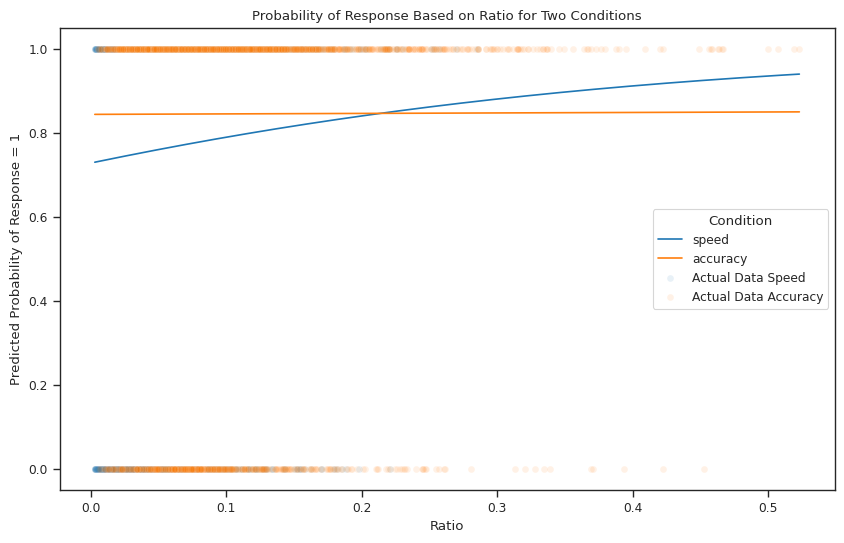

In [33]:
# Generate a range of ratio values
set_seaborn_style()
ratio_values = np.linspace(data['ratio'].min(), data['ratio'].max(), 8509)

# Create DataFrames for predictions for both conditions
predict_df_speed = pd.DataFrame({'ratio': ratio_values, 'SAT': 'speed', 'participant': data['participant'].iloc[0]})
predict_df_accuracy = pd.DataFrame({'ratio': ratio_values, 'SAT': 'accuracy', 'participant': data['participant'].iloc[0]})

# Predict the probabilities for both conditions
with conversion.localconverter(default_converter):
    predict_df_speed['predicted_prob'] = lmer_model.predict(predict_df_speed, skip_data_checks=True)
    predict_df_accuracy['predicted_prob'] = lmer_model.predict(predict_df_accuracy, skip_data_checks=True)

# Prepare the data for plotting
# Combine the prediction DataFrames
predict_df_speed['SAT'] = 'speed'
predict_df_accuracy['SAT'] = 'accuracy'
plot_data = pd.concat([predict_df_speed, predict_df_accuracy])
# plot_data = pd.DataFrame({
#     'ratio': np.tile(ratio_values, 2),
#     'predicted_probability': np.concatenate([predicted_probs_speed, predicted_probs_accuracy]),
#     'condition': ['speed'] * len(ratio_values) + ['accuracy'] * len(ratio_values)
# })

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=plot_data, x='ratio', y='predicted_prob', hue='SAT')
sns.scatterplot(data=data[data['SAT'] == 'speed'], x='ratio', y='response', alpha=0.1, label='Actual Data Speed')
sns.scatterplot(data=data[data['SAT'] == 'accuracy'], x='ratio', y='response', alpha=0.1, label='Actual Data Accuracy')

# Customize the plot
plt.xlabel('Ratio')
plt.ylabel('Predicted Probability of Response = 1')
plt.title('Probability of Response Based on Ratio for Two Conditions')
plt.legend(title='Condition')
plt.show()